In [1]:
import os , sys
sys.path.append(os.path.abspath('./cumulo_kronen'))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from analysis_tools import read_data
import seaborn as sns
from scipy.stats import norm

In [3]:
# Obtenemos los datos
df = read_data('./kronberger54.txt')

/home/jorgefederico/kronen/kronberger_project/analysis_tools.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [4]:
df

,dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
0,0.000161,1636148068921376768,Gaia DR3 2031062104120832768,2031062104120832768,1175274216,2016.0,300.783109,0.150290,31.966927,0.199653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000586,1636148068921376768,Gaia DR3 2031062104120834304,2031062104120834304,464100655,2016.0,300.783148,0.347544,31.967494,0.429691,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001059,1636148068921376768,Gaia DR3 2031062099824438784,2031062099824438784,768690384,2016.0,300.783560,0.081544,31.966030,0.106101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.001085,1636148068921376768,Gaia DR3 2031062104120840704,2031062104120840704,428127011,2016.0,300.781644,0.105442,31.967012,0.121241,...,2.8951,2.8226,3.017,2.1061,2.0487,2.2036,1.1631,1.1303,1.2186,MARCS
4,0.001101,1636148068921376768,Gaia DR3 2031062104125786624,2031062104125786624,1018135766,2016.0,300.783295,1.766230,31.967994,1.782304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,0.033236,1636148068921376768,Gaia DR3 2031015065626381312,2031015065626381312,1562815865,2016.0,300.791769,2.058824,31.934563,3.703061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1051,0.033244,1636148068921376768,Gaia DR3 2031015065626365568,2031015065626365568,438561186,2016.0,300.798980,0.213136,31.936617,0.290970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1052,0.033252,1636148068921376768,Gaia DR3 2031062756956051840,2031062756956051840,558535339,2016.0,300.776845,0.242653,31.999791,0.319811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1053,0.033268,1636148068921376768,Gaia DR3 2031061966701280256,2031061966701280256,736898489,2016.0,300.754945,0.291900,31.943630,0.330530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Conceptos introductorios

## Proper motion
Proper motion is the apparent angular motion of a star across the sky, as seen from Earth, due to its actual motion through space. It's measured in mas/year (milliarcseconds per year).

The total proper motion is the combination of both components: $\mu = \sqrt{pmra^{2} + pmdec^{2}}$

Where:
- pmra :  Proper Motion in Right Ascension
    - Unit: milliarcseconds per year (mas/yr)
- pmdec : Proper motion in Declination
    - Unit: milliarcseconds per year (mas/yr)

# Plane Plot

- Una vez obtenidos los datos hacemos un plane plot de los mismos
- Buscamos hacer zoom en la region donde haya mayor densidad


<Axes: xlabel='pmra', ylabel='pmdec'>

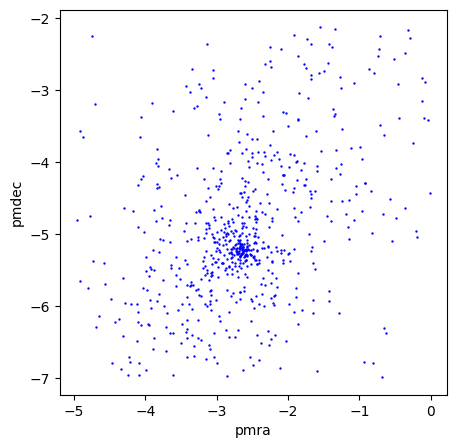

In [5]:
def plane_plot(df2, c='blue'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.scatter(df2.pmra,df2.pmdec, s=0.5, c=c)
    ax.set_xlabel('pmra')
    ax.set_ylabel('pmdec')
    return ax

def plot_color_magnitude(color, mag, c='blue'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.scatter(color,mag, s=0.9, c=c)
    ax.set_xlabel(color.name)
    ax.set_ylabel(mag.name)
    plt.gca().invert_yaxis()
    return ax

# Filtrar
df2 = df[(df.pmra>-5)&(df.pmra<0)&(df.pmdec<-2)&(df.pmdec>-7)]
# Plane plot
plane_plot(df2)

<Axes: xlabel='pmra', ylabel='Count'>

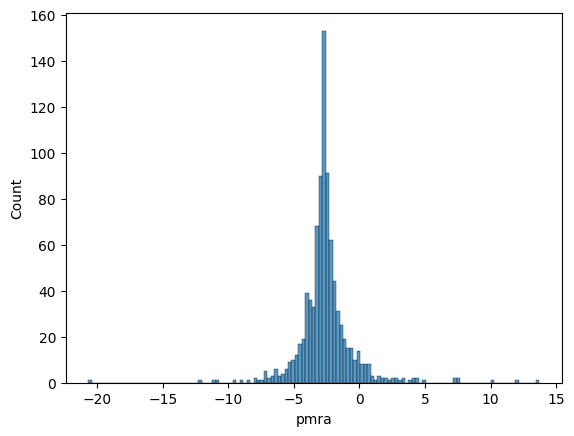

In [6]:
sns.histplot(df.pmra) # Histograma de movimientos propios (usando seaborn para plotear)

In [7]:
df.dropna(subset=['pmra', 'pmdec'], inplace=True) # Removemos los valores None , etc

In [8]:
np.mean(df.pmra) , np.mean(df.pmdec) , np.std(df.pmra) , np.std(df.pmdec) # Valores medios y de desviacion estandar de la distribucion

(np.float64(-2.5760829588036995),
 np.float64(-5.01204697878664),
 np.float64(2.1121624425594407),
 np.float64(2.6265044526506953))

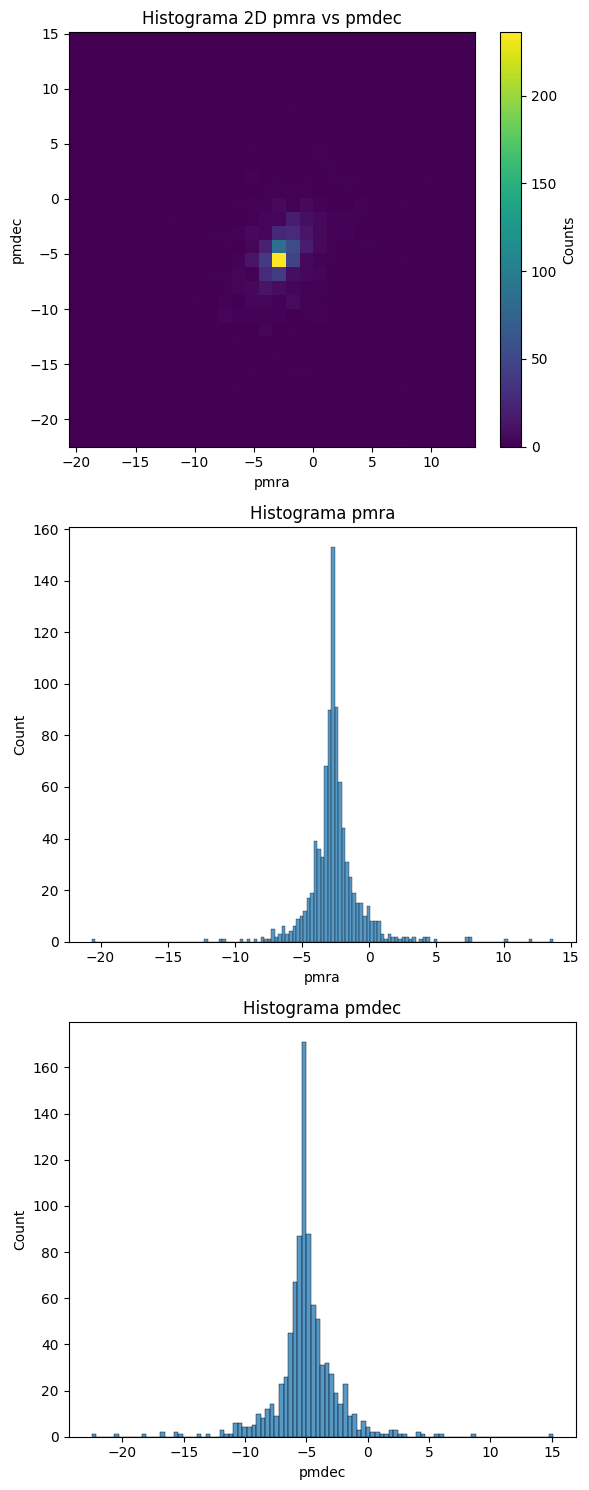

In [9]:
# En esta parte vamos a hacer el histograma 2D

# Calculamos histograma 2d con numpy
histo, xedges, yedges = np.histogram2d(df.pmra, df.pmdec, bins=(30, 30))

# Construimos un plot en matplotlib
fig, ax = plt.subplots(3, 1, figsize=(6, 15))

# 2D Histogram (imshow) (Facil para plotear rapido un histograma)
im = ax[0].imshow(histo.T, origin='lower', aspect='auto',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax[0].set_xlabel("pmra")
ax[0].set_ylabel("pmdec")
ax[0].set_title("Histograma 2D pmra vs pmdec")
fig.colorbar(im, ax=ax[0], label="Counts")  # Correct colorbar usage

# Seaborn histograma para pmra
sns.histplot(df.pmra.dropna(), ax=ax[1])
ax[1].set_title("Histograma pmra")

# Seaborn histograma para pmdec
sns.histplot(df.pmdec.dropna(), ax=ax[2])
ax[2].set_title("Histograma pmdec")

plt.tight_layout()
plt.show()


# Determinar el subset
- Vamos adeterminar bien el subconjunto con que vamos a trabajar
- Si hacemos una seleccion circular de los datos tendremos que usar una formula:

$$r=\sqrt{(x-a)^{2}+(y+b)^{2}}$$

- En topcat: Primero hay que hacer un plane plot > En la ventana del plot tendremos que usar la opcion *draw shape*. Cuando lo seleccionemos tendremos que darle un nombre: "comoving"


<Axes: xlabel='pmra', ylabel='pmdec'>

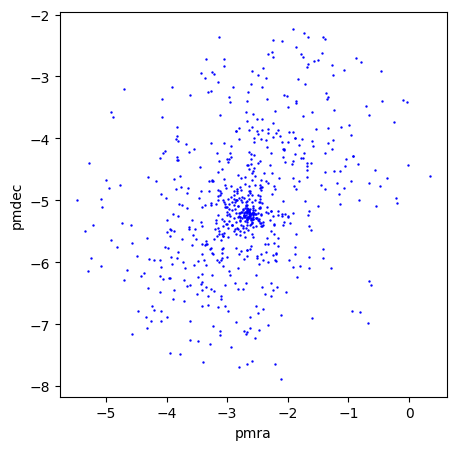

In [10]:
def circular_subset(center_ra, center_dec, radius):
    df_subset = df[
    ((df['pmra'] - center_ra) ** 2 + (df['pmdec'] - center_dec) ** 2) <= radius**2
    ]
    return df_subset

df_subset = circular_subset( # Uso la funcion de corte circular que genere mas arriba
    np.mean(df.pmra), # Valor a de la formula
    np.mean(df.pmdec), # Valor b de la formula
    3.0 # Valor r de la formula
    )

plane_plot(df_subset) # Uso el plane plot que cree para plotear en el espaio pmra, pmdec

# Histograma de Paralajes
- En topcat tenemos que ir a la ventana de histogram>Seleccionamos subset > seleccionamos la variable a plotear : *parallax* el cual es una columna de los datos.

- El paralaje es lo que utilizaremos para determinar la distancia, sin embargo, hay que remarcar que el mismo puede ser negativo. Esto puede deberse a multiples causas, entre las cuales se encuentran los errores de medicion. El siguiente video, explica las diversas formas en las que se puede obtener paralaje negativo: <a href="https://www.youtube.com/watch?v=q4SLDLGYd3o">Video</a>

- Haremos un gaussian fit para encontrar el centro de la distribucion en cuanto a paralaje y su desviacion estandar. Esto tambien nos permite separar objetos que esten fuera del cumulo, es decir objetos con paralajes distintos de la mayoria, asi como objetos con paralajes negativos.

- Paralajes cercanos a cero son para estrellas muy lejanas , esto da como resultado una mayor incerteza en el paralaje.

- Cabe aclarar igual que hay formas de trabajar con la paralaje negativa, sin embargo, para el presente se nos recomienda hacerlo con la positiva solamente.

## Importancia del error en el paralaje

- Debemos tambien tener en cuenta el error de la paralaje, el cual se encuentra en: *parallax_error*, concretamente vamos a buscar los objetos con error relativo tal que: $\frac{\Delta parallax}{parallax} < 0.3$

- Como me quedan muy pocos objetos, utilizo 0.5 como limite

<Axes: xlabel='parallax', ylabel='Count'>

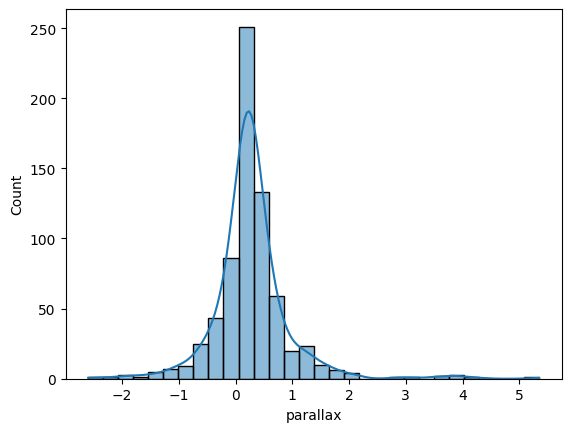

In [11]:
sns.histplot(df_subset.parallax, bins=30, kde=True) # Referencia para elaborar el histograma

In [12]:
h,b = np.histogram(df_subset.parallax, bins=30)

# calculamos el fit gaussiano
mu, std = norm.fit(df_subset.parallax)

# Con estos valores entonces restringiremos un poco mas los datos utilizando el paralaje (varaible parallax)
df_subset_2 = df_subset[(df_subset.parallax>mu)&(df_subset.parallax<mu+std)]



In [13]:
mu, mu+std, std # media, media + std , std

(np.float64(0.2787000262667171),
 np.float64(0.9639241612453321),
 np.float64(0.685224134978615))

<Axes: xlabel='parallax', ylabel='Count'>

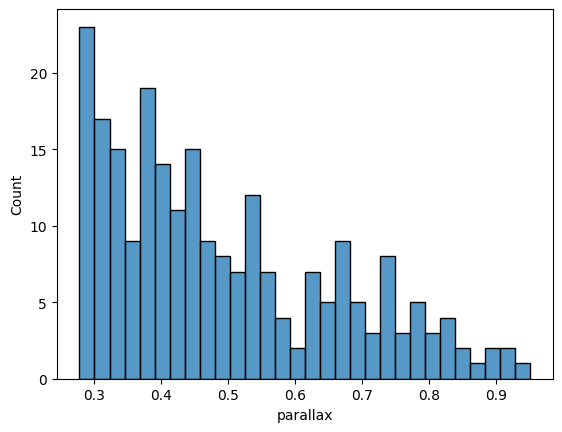

In [14]:
# Una vez hecho el corte ploteamos denuevo el histograma
sns.histplot(df_subset_2.parallax, bins=30)

In [15]:
# Ahora buscamos objetos cuyo error relativo en paralaje sea menor a algo
# gd = good distance
df_gd = df_subset_2[(df_subset_2.parallax_error/df_subset_2.parallax) < 0.15] # aca algo = 0.15



<Axes: xlabel='pmra', ylabel='pmdec'>

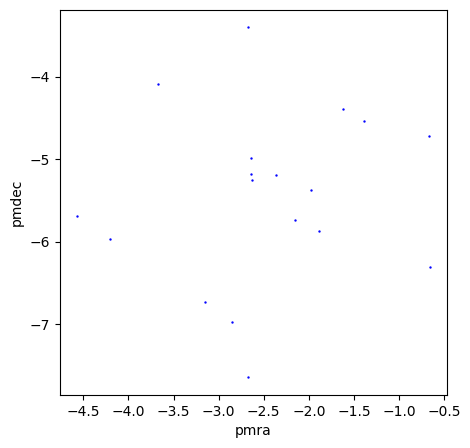

In [16]:
# Veamos que nos quedo:
plane_plot(df_gd)

# Grafico diagrama color maginitud

-  g_rp (or phot_rp_mean_mag in Gaia tables) is the mean magnitude in the RP band. It corresponds to flux measured through Gaia's Red Photometer, which covers the longer (redder) wavelengths, roughly 640–1050 nm.

- It is part of Gaia’s three-band photometry:
    - G: broad visible band (330–1050 nm)
    - BP: Blue Photometer (330–680 nm)
    - RP: Red Photometer (640–1050 nm)


- In Gaia DR3, the field phot_g_mean_mag refers to the mean apparent magnitude of a star in the Gaia G band, one of Gaia’s three broad photometric bands.


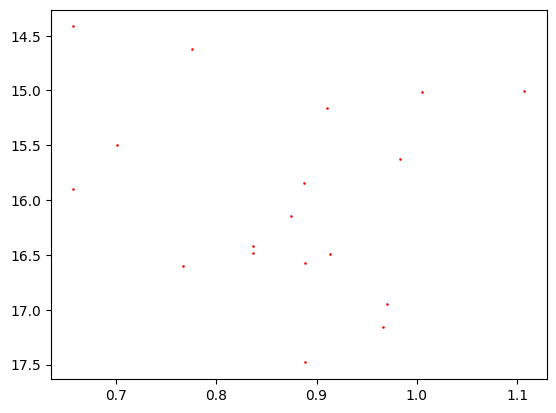

In [17]:
plt.scatter(df_gd.g_rp, df_gd.phot_g_mean_mag, s=0.7, c='red')
plt.gca().invert_yaxis() # No olvidarse inertir el eje y

# Ajuste de la isocrona

- Primero debemos obtener la distancia a partir de la paralaje $d = \frac{1}{parallax}$
- Hay que tener en cuenta en gaia dr3 las unidades del paralaje esta en *miliarcosegundos* , por lo cual para determinar la distancia usando la paralaje y que nos quede en parsec, debemos usar: $d = \frac{1000}{parallax}$

- Duda: Una opcion antes de hacer esto es calcular el paralaje medio y en base a este calcular las distancias

- A poserior debemos calcular la magnitud **Absoluta**, para ello usamos la formula de modulo de distancia: $M = m - 5log{\frac{d}{10[pc]}}$

In [18]:
parallax_mean = np.mean(df_gd.parallax)
distance_ = 1000/parallax_mean # Distancia asociada a la paralaje media
# Calculamos la magnitud ABSOLUTA (Formula de modulo distancia de arriba)
df_gd['abs_mag'] =np.array( df_gd.phot_g_mean_mag) -  5*np.log10(distance_/10)

/tmp/ipykernel_199880/2696976832.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gd['abs_mag'] =np.array( df_gd.phot_g_mean_mag) -  5*np.log10(distance_/10)


<Axes: xlabel='g_rp', ylabel='abs_mag'>

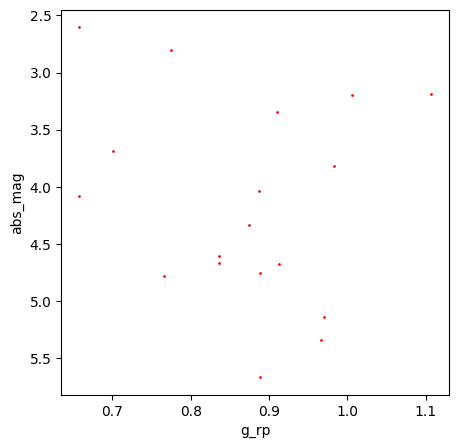

In [19]:
# plot de diagrama  color magnitud rapido
plot_color_magnitude(color=df_gd.g_rp, mag= df_gd.abs_mag, c='red')# Ahora con magnitud corregida

# Obtencion de la isocrona

Debemos is al siguiente <a href="https://stev.oapd.inaf.it/cgi-bin/cmd">Sitio</a>

- Evolutionary tracks> Version 1.2
- Photometric System> Gaia EDR3
- Circumstellar dust
    - Presencia de polvo estelar cambia la magnitud de esa estrella.
    - Nosotros estamos trabajando con cumulos abiertos, podemos pensar que no hay polvo
    - Elijo la opcion: No Dust
- Interstellar extinction
    - Valores de $A_{v}$ daran desplazamientos en el eje x
    - Queremos isocronas no desplazadas porque queremos corregir nuestra estrella segun la isocrona, de esta manera el corrimiento que hagamos a las estrellas en el eje x nos permitira obtener el enrojecimiento en esa region.
    - Esta variable **Debe quedar en cero** por los argumentos anteriormente mencionados.
- Long Period Variability> Lo dejamos tal como esta (valor 4)
    - Cambios solo seran necesarios si hay muchas estrellas en la region superior derecha del diagrama color magnitud.
- Initial mass function> Deralo tal y como esta
- Ages/metallicitie
    - Estamos trabajando con cumulos abiertos, los cuales tienen edades jovenes
    - Los valores de edad pueden ser o no logaritmicos, elegimos los no logaritmicos. Para valores no logaritmicos, un valor razonable es $5\times 10^{8}$, como valor inicial, mientras que para valor final tendriamos $5\times 10^{9}$
    - Un analisis del diagrama puede sugerir otros valores.
    - El valor de step para la edad debe elegirse con cuidado para que no sea pesado el archivo, se sugiere $1 \times 10^{8}$
    - Para cumulos abiertos, la metalicidad debe ser similar a la del sol
    - Para la metalicidad usamos el valor por defecto: 0.0152
    - Si queremos objetos mas jovenes que el sol, que serian mas metalicos, Z final deberia ser 0.03. Para el salto elegimos 0.01
- Outputs> sin cambios

- Esta lejos
- Enrojecido
- Masivas
- 10**7
- 10**9
- 10**7
- NO brillan en infrarrojo



- https://ucc.ar/_clusters/kronberger54/
- http://cdsportal.u-strasbg.fr/?target=kronberger%2054

- https://simbad.cds.unistra.fr/simbad/sim-id?Ident=DSH+J2003.1%2B3158&NbIdent=query_hlinks&Coord=20+03+07.9%2B31+58+01&children=32&submit=children&hlinksdisplay=h_all

In [20]:
isocron2 = read_data("./isocrona_2.dat")

/home/jorgefederico/kronen/kronberger_project/analysis_tools.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [21]:
# Aca repito todo lo anterior en una sola linea

df_gd2 = df_subset_2[(df_subset_2.parallax_error/df_subset_2.parallax) < 0.15]
parallax_mean2 = np.mean(df_gd2.parallax)
distance_2 = 1000/parallax_mean2 # Distancia asociada a la paralaje media
# Calculamos la magnitud
df_gd2['abs_mag'] =np.array( df_gd2.phot_g_mean_mag) -  5*np.log10(distance_2/10)

/tmp/ipykernel_199880/1572266665.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gd2['abs_mag'] =np.array( df_gd2.phot_g_mean_mag) -  5*np.log10(distance_2/10)


In [22]:
# Calculo de error (por propagacion de errores asociado a la distancia)
distance_2*np.std(df_gd2.parallax)/np.mean(df_gd2.parallax)

np.float64(764.1854460691291)

In [23]:
list(isocron2)

['Zini',
 'MH',
 'logAge',
 'Mini',
 'int_IMF',
 'Mass',
 'logL',
 'logTe',
 'logg',
 'label',
 'McoreTP',
 'C_O',
 'period0',
 'period1',
 'period2',
 'period3',
 'period4',
 'pmode',
 'Mloss',
 'tau1m',
 'X',
 'Y',
 'Xc',
 'Xn',
 'Xo',
 'Cexcess',
 'Z',
 'mbolmag',
 'Gmag',
 'G_BPmag',
 'G_RPmag']

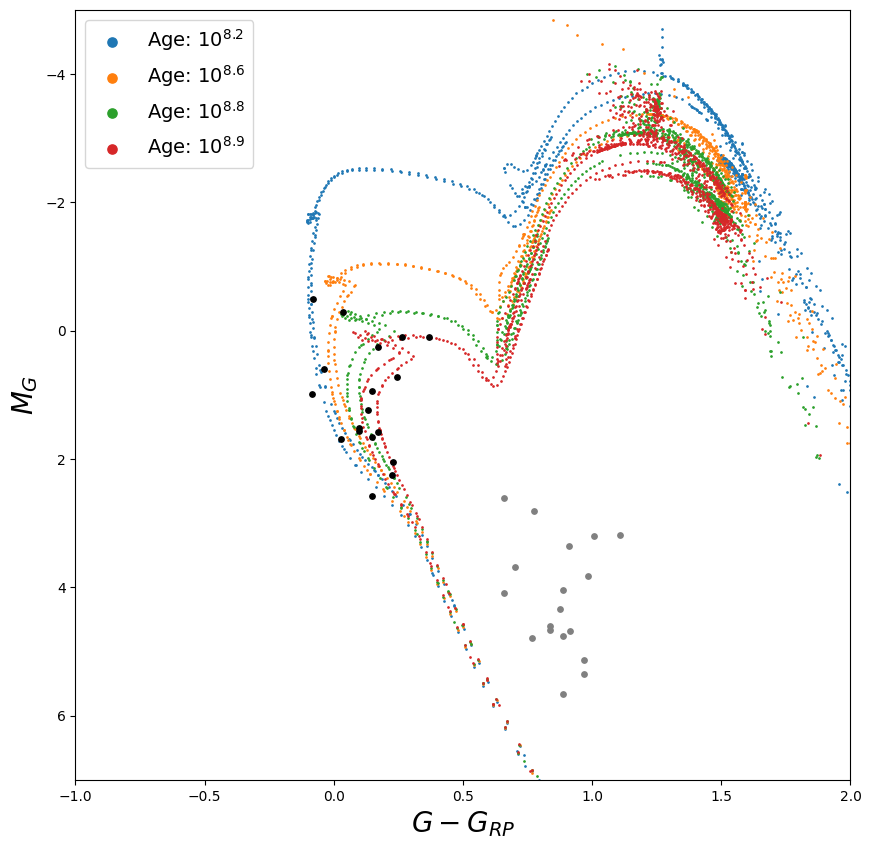

In [24]:
# isocron3 = isocron2[isocron2.logAge.isin([8.5,8.7,8.9])] # 7.5, 8., 8.5, 8.9


fig, ax = plt.subplots(1,1,figsize=(10,10))
for age in [8.2,8.6,8.8,8.9]: # Aca poner las edades de la isocrona que me interesen (disponibles siempre y cuando los haya descargado)

    x = isocron2[isocron2.logAge==age].Gmag - isocron2[isocron2.logAge==age].G_RPmag
    y = isocron2[isocron2.logAge==age].Gmag
    ax.scatter(x, y, s=0.9, label=fr"Age: $10^{{{age}}}$")
ax.scatter(df_gd2.g_rp-0.74, df_gd2.abs_mag - 3.1, c='black', s=15)

ax.scatter(df_gd2.g_rp, df_gd2.abs_mag, c='gray', s=15)
# ax.scatter(df_gd.phot_bp_rp_excess_factor, df_gd.abs_mag, c='red', s=5)

ax.set_xlabel(r'$G-G_{RP}$', fontsize=20)
ax.set_ylabel(r'$M_{G}$', fontsize=20)
ax.legend(fontsize=14, markerscale=7)
ax.set_ylim(-5, 7)
ax.set_xlim(-1, 2)
plt.gca().invert_yaxis()

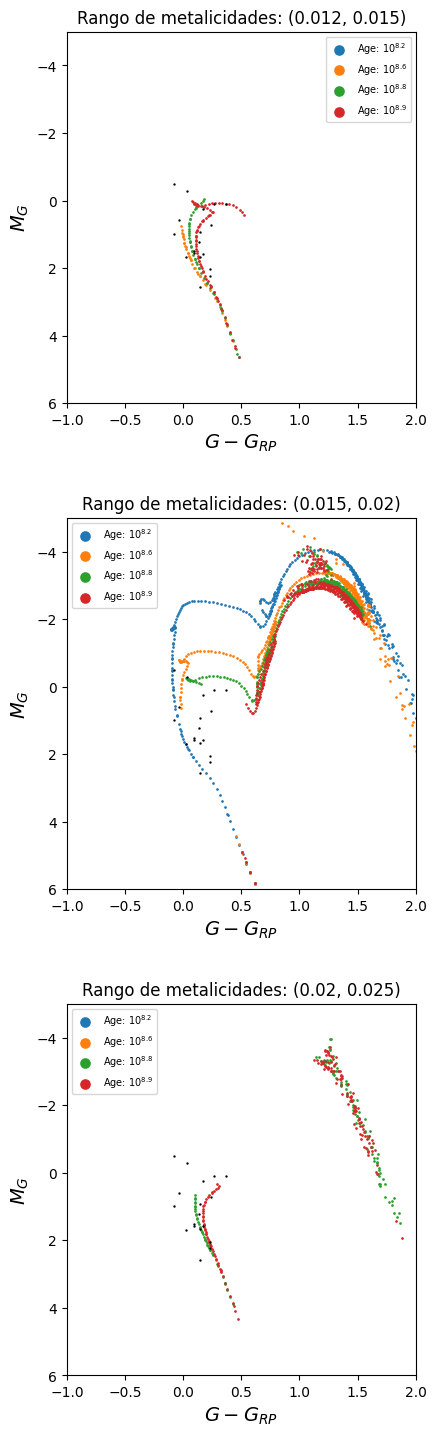

In [25]:

# Grafico para ir ploteando secciones de la isocrona segun rangos de metalicidades

z = ((0.012,0.015), (0.015,0.02), (0.02,0.025)) # Rangos de metalicidades
fig,axes = plt.subplots(3,1, figsize=(5,15))
for ax,z_ in zip(axes,z):
    for age in [8.2,8.6,8.8,8.9]:
        xx = isocron2[(isocron2.logAge==age)&(isocron2.Z < z_[1]) & (isocron2.Z > z_[0])].Gmag - isocron2[(isocron2.logAge==age)&(isocron2.Z < z_[1]) & (isocron2.Z > z_[0])].G_RPmag
        yy = isocron2[(isocron2.logAge==age)&(isocron2.Z < z_[1]) & (isocron2.Z > z_[0])].Gmag

        ax.scatter(xx, yy, s=0.9, label=fr"Age: $10^{{{age}}}$")
    ax.set_title(fr"Rango de metalicidades: {(z_[0], z_[1])}")
    ax.scatter(df_gd2.g_rp-0.74, df_gd2.abs_mag - 3.1, c='black', s=0.5)
    ax.set_xlabel(r'$G-G_{RP}$', fontsize=14)
    ax.set_ylabel(r'$M_{G}$', fontsize=14)
    ax.legend(fontsize=7, markerscale=7)
    ax.set_ylim(-5, 6)
    ax.set_xlim(-1, 2)
    ax.invert_yaxis()
fig.tight_layout(pad=3.0)
